<h2>Adaptive Control</h2>
Before using this document as a reference, please note that I'm just a student trying out more advanced control algorithms. Please let me know if there are any issues/holes with any of the formulation/theory that has been posted here. We are all here to learn :)
<h3>Define functions required </h3>
We first define all the required numerical methods that will be used in the main part of the program. Also, we define our mathematical model here.

In [22]:
import numpy as np 
import scipy as sp 
from matplotlib import pyplot as plt 

def f(q0, u, k):
    g = 9.81 
    if k == 0:
        m = 15
    else: 
        m = 25
    l = 0.5 
    T_in = u 
    q, q2 = q0 
    q_2dot = -g*l*np.sin(q) + T_in/m 
    q_dot = q2  

    return np.array([q_dot, q_2dot])

def rk4(x0, u, h,  flag):
    k1 = f(x0, u, flag)
    k2 = f(x0 + h*(k1/2), u, flag)
    k3 = f(x0 + h*(k2/2), u, flag)
    k4 = f(x0 + h*k3, u, flag)

    return h*((k1 + 2*k2 + 2*k3 + k4)/6)

def euler_diff(x, y, h):
    diff = (x-y)/h 
    return diff 

def euler_int(x0,dx,h):
    x0 = x0+dx*h
    return x0

<h3>Define parameters required </h3> Over here, we have to define all the required terms that will be used in the control law itself. Note that the adaptive law here is $\hat{\theta}$. So, we need to integrate $\dot{\hat{\theta}}$ so that our system to adapt to its unknown parameters. In this case, we use Euler integration to integrate $$\int_0^T \dot{\hat{\theta}} dt$$. The other terms here are further explained in the other LaTeX pdf file in this folder. One last thing to note here is that the term "flag" changes our unknown parameters midway through the simulation.

In [23]:
l = 0.5
m = 15 
g = 9.81 
N = 250
x0 = np.array([0.2, 0.2])
t = np.zeros(N+1) 
e = np.zeros(N+1)
u = np.zeros(N+1)
x = np.zeros([N+1,2])
h = 0.05
alpha = 5 # for filter tracking error
gamma = np.array([[3,0],[0,3]])
gamma_inv = np.linalg.inv(gamma)
k = 100
r = np.zeros(N+1)
sim_t = 0 
x[0] = x0
trajectory = np.zeros(N+1) 
e_dot = np.zeros(N+1)
Y = np.zeros([N+1,2])
theta_hat_dot = np.zeros([N+1, 2])
theta_hat = np.zeros([N+1,2]) 
theta_hat[0] = np.array([0, 0])
V_dot = np.zeros(N+1) #Lyapunov derivative
V = np.zeros(N+1) #Lyapunov 
theta = np.array([m, m*l])
flag = 0 

<h3>Run through simulation. </h3> The simulation here is written in a way such that we update our states of the system iteratively. Most importantly, we create our trajectory here as a function of time for our controller to track. 

In [24]:
for i in range(N):
    sim_t += h
    t[i+1] = sim_t
    # trajectory[i+1] = 0.85 - 0.85*np.exp(-t[i+1]) 
    trajectory[i+1] = 0.5*np.sin(t[i+1]) + 0.5*np.cos(0.5*t[i+1]) #generate some trajectory
    e[i+1] = trajectory[i+1] - x[i,0]
    if i > 0:
        e_dot[i+1] = euler_diff(e[i+1], e[i], h) #only start differentiation at iteration 2 
    r[i+1] = e_dot[i+1] + alpha*e[i+1]
    Y[i+1, 0] = trajectory[i+1] + alpha*e[i+1]
    Y[i+1, 1] = g*np.sin(x[i, 0])
    Y_T = np.transpose(Y[i+1])
    theta_hat_dot[i+1] = np.dot(gamma,Y[i+1])*r[i+1] 
    theta_hat[i+1] = euler_int(theta_hat[i] ,theta_hat_dot[i+1], h)
    u[i] = np.dot(Y_T, theta_hat[i+1]) + k*r[i+1]
    if i > 100:
        flag = 1
    x0 = x0 + rk4(x0, u[i], h, flag)
    x[i+1] = x0 
    v = 0.5*m*r[i+1]**2 + 0.5*np.dot(np.dot((theta-theta_hat[i+1]), gamma_inv), np.transpose(theta-theta_hat[i+1]))
    V[i+1] = v
    vdot = -k*r[i+1]**2
    V_dot[i+1] = vdot

<h3>Plot Results </h3>

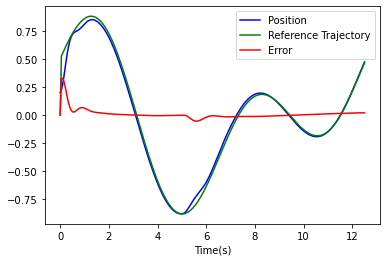

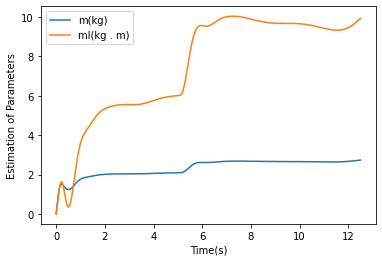

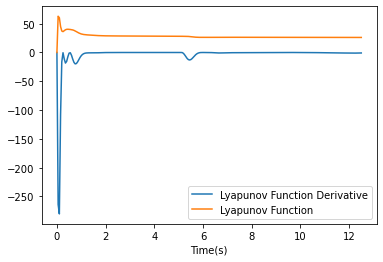

In [25]:
plt.plot(t, x[:,0], 'blue', label = 'Position')
plt.plot(t, trajectory, 'green', label = 'Reference Trajectory')
plt.plot(t, e, 'red', label = 'Error')
plt.xlabel("Time(s)", fontsize = 10)
plt.legend(fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

plt.plot(t, theta_hat[:,0], label = 'm(kg)')
plt.plot(t, theta_hat[:,1], label = 'ml(kg . m)')
plt.legend(fontsize = 10)
plt.xlabel("Time(s)", fontsize = 10)
plt.ylabel("Estimation of Parameters", fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

plt.plot(t, V_dot, label = 'Lyapunov Function Derivative')
plt.plot(t, V, label = 'Lyapunov Function')
plt.xlabel("Time(s)", fontsize = 10)
plt.legend(fontsize = 10, loc = 'lower right')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

<h3>Using PD Controller only</h3>
As we can see here, the difference in results beteen using a PD controller and adaptive controller makes a noticeable difference. The PD controller cannot track the desired trajectory as well as the adaptive controller when the system is subjected to uncertanties. Because our system is not terribly non-linear, the difference between a PD controller and adaptive controller may not be as drastic in this example. However, we can still tell that tracking with an adaptive controller is still more robust than a regular PD controller.

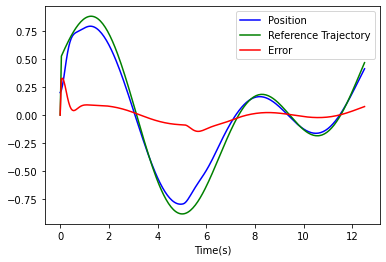

In [26]:
import numpy as np 
import scipy as sp 
from matplotlib import pyplot as plt 

def f(q0, u, k):
    g = 9.81 
    if k == 0:
        m = 15
    else: 
        m = 25
    l = 0.5 
    T_in = u 
    q, q2 = q0 
    q_2dot = -g*l*np.sin(q) + T_in/m 
    q_dot = q2  

    return np.array([q_dot, q_2dot])

def rk4(x0, u, h,  flag):
    k1 = f(x0, u, flag)
    k2 = f(x0 + h*(k1/2), u, flag)
    k3 = f(x0 + h*(k2/2), u, flag)
    k4 = f(x0 + h*k3, u, flag)

    return h*((k1 + 2*k2 + 2*k3 + k4)/6)

def euler_diff(x, y, h):
    diff = (x-y)/h 
    return diff 

def euler_int(x0,dx,h):
    x0 = x0+dx*h
    return x0

l = 0.5
m = 15 
g = 9.81 
N = 250
x0 = np.array([0.2, 0.2])
t = np.zeros(N+1) 
e = np.zeros(N+1)
u = np.zeros(N+1)
x = np.zeros([N+1,2])
h = 0.05
alpha = 5 # for filter tracking error
gamma = np.array([[3,0],[0,3]])
gamma_inv = np.linalg.inv(gamma)
k = 100
r = np.zeros(N+1)
sim_t = 0 
x[0] = x0
trajectory = np.zeros(N+1) 
e_dot = np.zeros(N+1)
Y = np.zeros([N+1,2])
theta_hat_dot = np.zeros([N+1, 2])
theta_hat = np.zeros([N+1,2]) 
theta_hat[0] = np.array([0, 0])
V_dot = np.zeros(N+1) #Lyapunov derivative
V = np.zeros(N+1) #Lyapunov 
theta = np.array([m, m*l])
flag = 0 

for i in range(N):
    sim_t += h
    t[i+1] = sim_t
    # trajectory[i+1] = 0.85 - 0.85*np.exp(-t[i+1]) 
    trajectory[i+1] = 0.5*np.sin(t[i+1]) + 0.5*np.cos(0.5*t[i+1]) #generate some trajectory
    e[i+1] = trajectory[i+1] - x[i,0]
    if i > 0:
        e_dot[i+1] = euler_diff(e[i+1], e[i], h) #only start differentiation at iteration 2 
    r[i+1] = e_dot[i+1] + alpha*e[i+1]
    Y[i+1, 0] = trajectory[i+1] + alpha*e[i+1]
    Y[i+1, 1] = g*np.sin(x[i, 0])
    Y_T = np.transpose(Y[i+1])
    theta_hat_dot[i+1] = np.dot(gamma,Y[i+1])*r[i+1] 
    theta_hat[i+1] = euler_int(theta_hat[i] ,theta_hat_dot[i+1], h)
    u[i] = k*r[i+1]
    if i > 100:
        flag = 1
    x0 = x0 + rk4(x0, u[i], h, flag)
    x[i+1] = x0 

plt.plot(t, x[:,0], 'blue', label = 'Position')
plt.plot(t, trajectory, 'green', label = 'Reference Trajectory')
plt.plot(t, e, 'red', label = 'Error')
plt.xlabel("Time(s)", fontsize = 10)
plt.legend(fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

<h3>Final Comments</h3>
As we can see here, the estimation of parameters do not necessarily converge to the true value. More importantly, we can see that our system is actually stable. We can further tune our systems to get even better tracking performances. Our Lyapunov function $V$ and its derivative $\dot{V}$ is positive definite and negative semidefinite respectively.